## Create SparkSession

In [27]:
# import necessary libaries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as matplot

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, min, max, mean, to_date, year, month

# Create a SparkSession
spark = SparkSession.builder.appName("WeatherAnalysis").getOrCreate()

## Show databases from HIVE

In [2]:
spark.sql("show databases").show()

2024-12-07 14:24:02,714 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2024-12-07 14:24:02,717 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist


+---------+
|namespace|
+---------+
|  default|
|     mydb|
+---------+



## Use mydb database

In [3]:
spark.sql('use mydb')

2024-12-07 14:24:12,233 WARN metastore.ObjectStore: Failed to get database global_temp, returning NoSuchObjectException


DataFrame[]

## Show mydb tables

In [4]:
spark.sql('show tables').show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
|    mydb|             authors|      false|
|    mydb|                cars|      false|
|    mydb|weather_data_part...|      false|
+--------+--------------------+-----------+



## Show Columns

In [5]:
spark.sql('show columns in weather_data_partitioned_by_month').show()

+--------------------+
|            col_name|
+--------------------+
|                Date|
|                Time|
| Water_Content_m3_m3|
|Solar_Radiation_W_m2|
|             Rain_mm|
| Temperature_Celsius|
|          RH_percent|
|      Wind_Speed_m_s|
|      Gust_Speed_m_s|
|Wind_Direction_De...|
|   Dew_Point_Celsius|
|               month|
+--------------------+



## Describe Data

In [6]:
spark.sql('desc weather_data_partitioned_by_month').show()

+--------------------+---------+-------+
|            col_name|data_type|comment|
+--------------------+---------+-------+
|                Date|     date|   null|
|                Time|   string|   null|
| Water_Content_m3_m3|   double|   null|
|Solar_Radiation_W_m2|   double|   null|
|             Rain_mm|   double|   null|
| Temperature_Celsius|   double|   null|
|          RH_percent|   double|   null|
|      Wind_Speed_m_s|   double|   null|
|      Gust_Speed_m_s|   double|   null|
|Wind_Direction_De...|   double|   null|
|   Dew_Point_Celsius|   double|   null|
|               month|   string|   null|
|# Partition Infor...|         |       |
|          # col_name|data_type|comment|
|               month|   string|   null|
+--------------------+---------+-------+



## Load Data into Dataframe

In [12]:
df = spark.sql("SELECT * FROM mydb.weather_data_partitioned_by_month")

## Basic Statistical Summary

In [13]:
numeric_columns = [
    "Temperature_Celsius", 
    "Solar_Radiation_W_m2", 
    "Rain_mm", 
    "Wind_Speed_m_s"
]
summary_stats = df.select([
    avg(col(c)).alias(f"Avg_{c}") for c in numeric_columns
] + [
    min(col("Temperature_Celsius")).alias("Min_Temperature"),
    max(col("Temperature_Celsius")).alias("Max_Temperature")
])

In [14]:
print(type(df))

<class 'pyspark.sql.dataframe.DataFrame'>


## Monthly Temperature Analysis

In [31]:
monthly_temp = df.withColumn("full_date", to_date(col("Date"), "yyyy-MM-dd")) \
    .groupBy(year(col("full_date")).alias("year"), month(col("full_date")).alias("month")) \
    .agg(
        avg(col("Temperature_Celsius")).alias("Avg_Temperature"),
        min(col("Temperature_Celsius")).alias("Min_Temperature"),
        max(col("Temperature_Celsius")).alias("Max_Temperature")
    ).orderBy("year", "month")

monthly_temp_pandas = monthly_temp.toPandas()

## Visualization 1: Monthly Temperature Variation

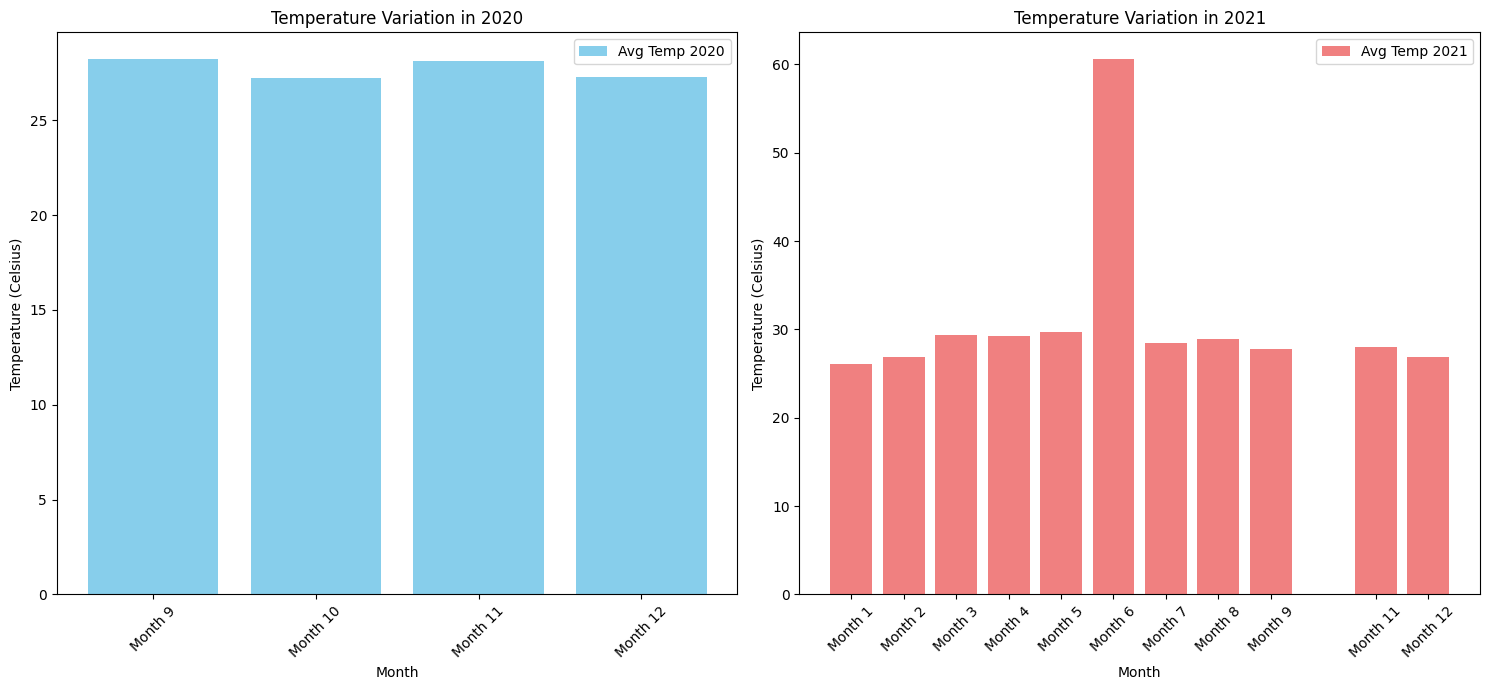

In [33]:
# Create bar charts for temperature variations
plt.figure(figsize=(15, 7))

# Plot for 2020
plt.subplot(1, 2, 1)
year_2020 = monthly_temp_pandas[monthly_temp_pandas['year'] == 2020]
plt.bar(year_2020['month'], year_2020['Avg_Temperature'], color='skyblue', label='Avg Temp 2020')
plt.title('Temperature Variation in 2020')
plt.xlabel('Month')
plt.ylabel('Temperature (Celsius)')
plt.xticks(year_2020['month'], labels=[f'Month {m}' for m in year_2020['month']], rotation=45)
plt.legend()

# Plot for 2021
plt.subplot(1, 2, 2)
year_2021 = monthly_temp_pandas[monthly_temp_pandas['year'] == 2021]
plt.bar(year_2021['month'], year_2021['Avg_Temperature'], color='lightcoral', label='Avg Temp 2021')
plt.title('Temperature Variation in 2021')
plt.xlabel('Month')
plt.ylabel('Temperature (Celsius)')
plt.xticks(year_2021['month'], labels=[f'Month {m}' for m in year_2021['month']], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

## Correlation Analysis

In [34]:
correlation_columns = [
    'Temperature_Celsius', 'Solar_Radiation_W_m2', 
    'Rain_mm', 'Wind_Speed_m_s', 'RH_percent'
]

correlation_df = df.select(correlation_columns)
correlation_matrix = correlation_df.toPandas().corr()

## Visualization 2: Correlation Heatmap

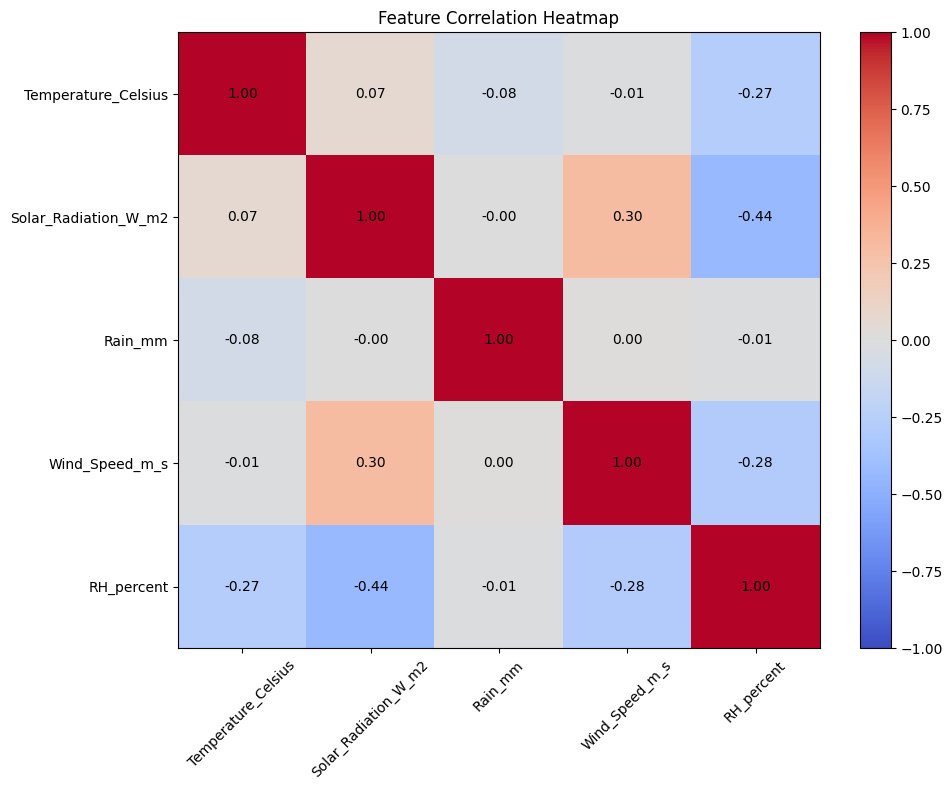

In [35]:
plt.figure(figsize=(10, 8))
im = plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(im)
plt.title('Feature Correlation Heatmap')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

# Annotate correlation values
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                 ha='center', va='center', color='black')

plt.tight_layout()
plt.show()
plt.savefig('correlation_heatmap.png')
plt.close()

## Seasonal Wind Speed Analysis

In [40]:
cleaned_df = df.filter((col("Gust_Speed_m_s") >= 0) & (col("Gust_Speed_m_s") < 50))  # Adjust 50 to the expected max gust speed

# Group by year and month after cleaning
wind_by_year_month = cleaned_df.withColumn("full_date", to_date(col("Date"), "yyyy-MM-dd")) \
    .groupBy(year(col("full_date")).alias("year"), month(col("full_date")).alias("month")) \
    .agg(
        avg(col("Wind_Speed_m_s")).alias("Avg_Wind_Speed"),
        avg(col("Gust_Speed_m_s")).alias("Avg_Gust_Speed")
    ).orderBy("year", "month")

wind_by_year_month_pandas = wind_by_year_month.toPandas()

## Visualization 3: Wind Speed Comparison

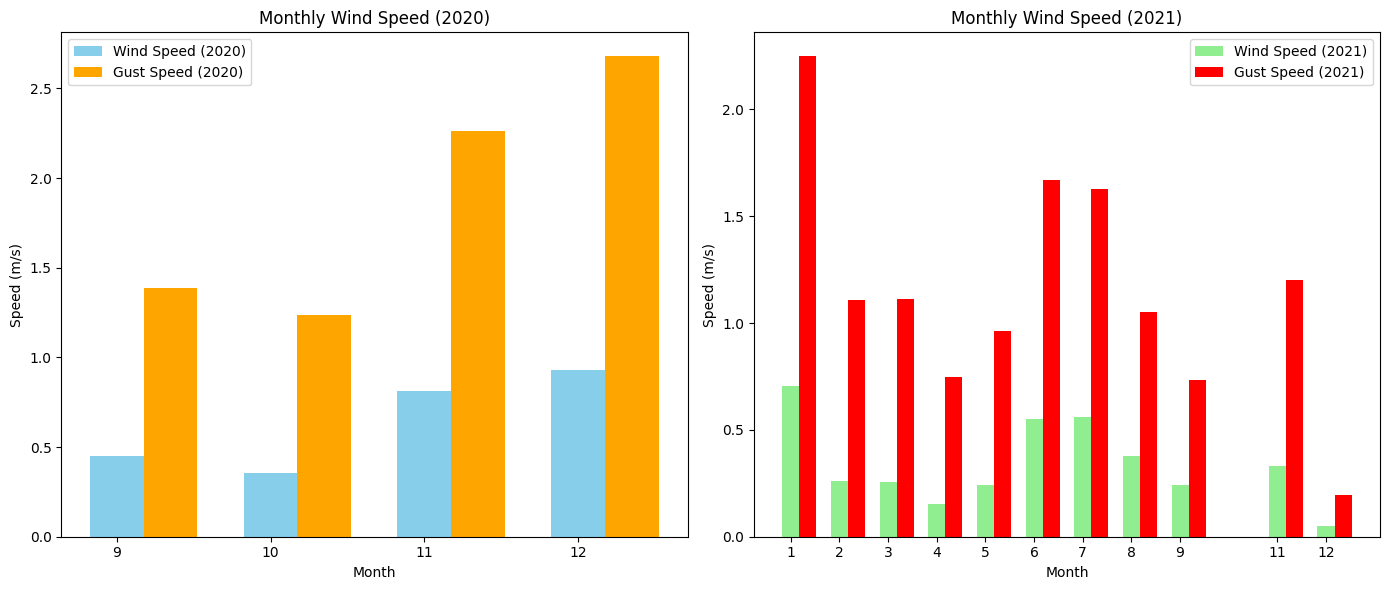

In [41]:
plt.figure(figsize=(14, 6))

# Plot for 2020
plt.subplot(1, 2, 1)
wind_2020 = wind_by_year_month_pandas[wind_by_year_month_pandas['year'] == 2020]
width = 0.35
plt.bar(wind_2020['month'], wind_2020['Avg_Wind_Speed'], width, label='Wind Speed (2020)', color='skyblue')
plt.bar(wind_2020['month'] + width, wind_2020['Avg_Gust_Speed'], width, label='Gust Speed (2020)', color='orange')
plt.title('Monthly Wind Speed (2020)')
plt.xlabel('Month')
plt.ylabel('Speed (m/s)')
plt.xticks(wind_2020['month'])
plt.legend()

# Plot for 2021
plt.subplot(1, 2, 2)
wind_2021 = wind_by_year_month_pandas[wind_by_year_month_pandas['year'] == 2021]
plt.bar(wind_2021['month'], wind_2021['Avg_Wind_Speed'], width, label='Wind Speed (2021)', color='lightgreen')
plt.bar(wind_2021['month'] + width, wind_2021['Avg_Gust_Speed'], width, label='Gust Speed (2021)', color='red')
plt.title('Monthly Wind Speed (2021)')
plt.xlabel('Month')
plt.ylabel('Speed (m/s)')
plt.xticks(wind_2021['month'])
plt.legend()

plt.tight_layout()
plt.show()